In [1]:
import pytorch_lightning as pl
from transformers import DetrConfig, DetrForObjectDetection
import torch
import matplotlib.pyplot as plt
    
class Detr(pl.LightningModule):
    def __init__(self, lr, lr_backbone, weight_decay):
        super().__init__()
        # replace COCO classification head with custom head
        # we specify the "no_timm" variant here to not rely on the timm library
        # for the convolutional backbone
        self.model = DetrForObjectDetection.from_pretrained("C:/Salil Data/Salil/Salil FAU/MSc ACES/Sem 2 Courses/Tracking Olympiad/Trained/DETR resnet50 default/Full_trainable/5_queries/auxloss_true",
                                                            revision="no_timm",
                                                            num_labels=1,
                                                            ignore_mismatched_sizes=True)
        # Set all parameters as trainable
        for param in self.model.parameters():
            param.requires_grad = True

        # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896
        self.lr = lr
        self.lr_backbone = lr_backbone
        self.weight_decay = weight_decay

    def forward(self, pixel_values, pixel_mask):
        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

        return outputs

    def common_step(self, batch, batch_idx):
        pixel_values = batch["pixel_values"]
        pixel_mask = batch["pixel_mask"]
        labels = [{k: v.to(self.device) for k, v in t.items()} for t in batch["labels"]]

        outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask, labels=labels)

        loss = outputs.loss
        loss_dict = outputs.loss_dict

        return loss, loss_dict

    def training_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        # logs metrics for each training_step,
        # and the average across the epoch
        self.log("training_loss", loss)
        for k, v in loss_dict.items():
            self.log("train_" + k, v.item())

        return loss

    def validation_step(self, batch, batch_idx):
        loss, loss_dict = self.common_step(batch, batch_idx)
        self.log("validation_loss", loss)
        for k, v in loss_dict.items():
            self.log("validation_" + k, v.item())

        return loss

    def configure_optimizers(self):
        param_dicts = [
            {"params": [p for n, p in self.named_parameters() if "backbone" not in n and p.requires_grad]},
            {
                "params": [p for n, p in self.named_parameters() if "backbone" in n and p.requires_grad],
                "lr": self.lr_backbone,
            },
        ]
        optimizer = torch.optim.AdamW(param_dicts, lr=self.lr,
                                      weight_decay=self.weight_decay)

        return optimizer

    def train_dataloader(self):
        return train_dataloader

    def val_dataloader(self):
        return val_dataloader

model = Detr(lr=1e-4, lr_backbone=1e-5, weight_decay=1e-4)

Some weights of DetrForObjectDetection were not initialized from the model checkpoint at C:/Salil Data/Salil/Salil FAU/MSc ACES/Sem 2 Courses/Tracking Olympiad/Trained/DETR resnet50 default/Full_trainable/5_queries/auxloss_true and are newly initialized because the shapes did not match:
- model.query_position_embeddings.weight: found shape torch.Size([100, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [2]:
model.parameters()

<generator object Module.parameters at 0x000002775EDB1F20>

In [15]:
# Load the checkpoint
checkpoint_path = "C:/Salil Data/Salil/Salil FAU/MSc ACES/Sem 2 Courses/Tracking Olympiad/Trained/DETR resnet50 default/Full_trainable/5_queries/auxloss_true/bboxloss_inc/logstensorboard/DETR_Full_trainable_ogr_size_5_queries/version_2/checkpoints/epoch=24-step=3700.ckpt"
checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))

# Load the model state dictionary from the checkpoint
model.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [4]:
import torchvision
import os
import torchvision.transforms as transforms

class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(self, img_folder, processor, purpose=None):
        if purpose=='train':
            ann_file = os.path.join(img_folder, "RGB_train.json")
        if purpose=='val':
            ann_file = os.path.join(img_folder, "RGB_val.json")
        if purpose=='test':
            ann_file = os.path.join(img_folder, "test.json")
        super(CocoDetection, self).__init__(img_folder, ann_file)
        self.processor = processor

    def __getitem__(self, idx):
        # read in PIL image and target in COCO format
        # feel free to add data augmentation here before passing them to the next step
        img, target = super(CocoDetection, self).__getitem__(idx)
        
        # preprocess image and target (converting target to DETR format, resizing + normalization of both image and target)
        image_id = self.ids[idx]
        target = {'image_id': image_id, 'annotations': target}
        encoding = self.processor(images=img, annotations=target, return_tensors="pt")
        pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
        target = encoding["labels"][0] # remove batch dimension
        
#         import torch
#         import torchvision.transforms as transforms
#         from torchvision.transforms import GaussianBlur

#         to_pil_transform = transforms.ToPILImage()
#         pixel_values = to_pil_transform(pixel_values)

#         Create the augmentation transforms
#         transform = transforms.Compose([
#             torchvision.transforms.ColorJitter(brightness=(0.7,1.3), contrast=(0.7,1.3), saturation=(0.7,1.3), hue=(-0.1, 0.1))
            
#         ])

    
#         pixel_values = transform(pixel_values)
#         pixel_values = pixel_values[[2, 1, 0], :, :] 

        # Add Gaussian noise to an image tensor
#         noise_transform = transforms.Compose([

#             transforms.RandomApply([transforms.GaussianBlur(kernel_size=7, sigma=(0.1, 25.0))])
#         ])

#         pixel_values = noise_transform(pixel_values)

#         elastic_transformer = transforms.ElasticTransform(alpha=20.0)
#         pixel_values = elastic_transformer(pixel_values)
#         posterize_transformer = transforms.RandomPosterize(bits=2)
#         pixel_values = posterize_transformer(pixel_values)

        # Simulate motion blur on an image tensor
#         motion_blur_transform = transforms.Compose([
#             transforms.ToPILImage(),
#             transforms.RandomApply([GaussianBlur(kernel_size=1)]),
#             transforms.ToTensor()
#         ])

#         pixel_values = motion_blur_transform(pixel_values)

        return pixel_values, target

In [5]:
from transformers import DetrImageProcessor


processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")

C:\Users\salil\anaconda3\lib\site-packages\transformers\models\detr\image_processing_detr.py:780: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


In [8]:
train_dataset = CocoDetection(img_folder='C:\\Salil Data\\Salil\\Salil FAU\\MSc ACES\\Sem 2 Courses\\Tracking Olympiad\\Train data\\Training data\\org_size\\new_RGB_data1\\train', processor=processor, purpose='train')
val_dataset = CocoDetection(img_folder='C:\\Salil Data\\Salil\\Salil FAU\\MSc ACES\\Sem 2 Courses\\Tracking Olympiad\\Train data\\Training data\\org_size\\new_RGB_data1\\val', processor=processor, purpose='val')
test_dataset = CocoDetection(img_folder='C:\\Salil Data\\Salil\\Salil FAU\\MSc ACES\\Sem 2 Courses\\Tracking Olympiad\\Train data\\Training data\\org_size\\new_RGB_data1\\test_for_train5', processor=processor, purpose='test')

loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [9]:

from torch.utils.data import DataLoader

def collate_fn(batch):
    pixel_values = [item[0] for item in batch]
    encoding = processor.pad(pixel_values, return_tensors="pt")
    labels = [item[1] for item in batch]
    batch = {}
    batch['pixel_values'] = encoding['pixel_values']
    batch['pixel_mask'] = encoding['pixel_mask']
    batch['labels'] = labels
    return batch


train_dataloader = DataLoader(train_dataset, collate_fn=collate_fn, batch_size=1, shuffle=True)
val_dataloader = DataLoader(val_dataset, collate_fn=collate_fn, batch_size=1)
test_dataloader = DataLoader(test_dataset, collate_fn=collate_fn, batch_size=1)

batch = next(iter(test_dataloader))
len(test_dataloader)

C:\Users\salil\anaconda3\lib\site-packages\transformers\models\detr\image_processing_detr.py:886: FutureWarning: The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
  warnings.warn(


505

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


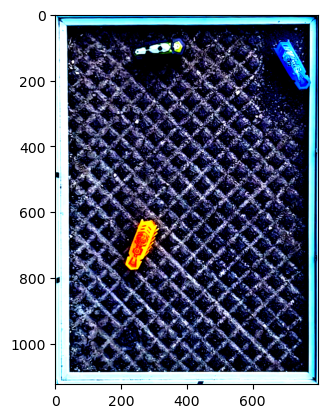

In [10]:
import matplotlib.pyplot as plt
plt.imshow(batch['pixel_values'][0].numpy().transpose(1,2,0))

In [17]:
%%timeit -n3
outputs = model(pixel_values=batch['pixel_values'], pixel_mask=None)

KeyboardInterrupt: 

In [11]:
import matplotlib.pyplot as plt
from PIL import Image

def plot_results(pil_img, scores, labels, boxes, index):
    print(pil_img.size)
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for score, label, (xmin, ymin, xmax, ymax),c  in zip(scores.tolist(), labels.tolist(), boxes.tolist(), colors):
#         ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
#                                    fill=False, color=c, linewidth=3))
        center = (xmin+32.5, ymin+32.5)
        print(center)
        radius = 15
        ax.add_artist(plt.Circle(center, radius, edgecolor='black', facecolor='blue'))
#         text = f'{model.config.id2label[label]}: {score:0.2f}'
        text = f'Hexbug head: {score:0.2f}'
        ax.text(xmin, ymin, text, fontsize=7,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
#     plt.savefig("C:\\Salil Data\\Salil\\Salil FAU\\MSc ACES\\Sem 2 Courses\\Tracking Olympiad\\Trained\\DETR resnet50 default\\Full_trainable\\5_queries\\auxloss_true\\bboxloss_inc\\Gaussian_Color\\valProbs_V27\\image_" + str(index) + ".jpg")
    
#     plt.show()

In [53]:
# index = [250]

In [15]:

for ind in index:
    #We can use the image_id in target to know which image it is
    pixel_values, target = test_dataset[ind]
    print(target['boxes'])

    device = torch.device( "cuda")
    pixel_values = pixel_values.unsqueeze(0).to(device)
    model.to(device)

    with torch.no_grad():
      # forward pass to get class logits and bounding boxes
      outputs = model(pixel_values=pixel_values, pixel_mask=None)
    # print("Outputs:", outputs.keys())

    # colors for visualization
    COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
              [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

    # load image based on ID
    image_id = target['image_id'].item()
    image = val_dataset.coco.loadImgs(image_id)[0]
    image = Image.open(os.path.join('C:\\Salil Data\\Salil\\Salil FAU\\MSc ACES\\Sem 2 Courses\\Tracking Olympiad\\Train data\\Training data\\org_size\\new_RGB_data1\\test_for_train5\\', image['file_name']))

    # postprocess model outputs
    width, height = image.size
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.5)
    results = postprocessed_outputs[0]

    plot_results(image, results['scores'], results['labels'], results['boxes'], ind)


NameError: name 'index' is not defined

In [16]:

device = torch.device( "cuda")
model.to(device)
index=[]

thresholds = [0.65]
for ind in thresholds:
    index=[]
    true_positive = 0
    false_positive = 0
    false_negative = 0
    for i in range(505):
        #We can use the image_id in target to know which image it is
        pixel_values, target = test_dataset[i]
        pixel_values = pixel_values.unsqueeze(0).to(device) 

        with torch.no_grad():
            # forward pass to get class logits and bounding boxes
            outputs = model(pixel_values=pixel_values, pixel_mask=None)

        # postprocess model outputs
        width = target['size'][0]
        height = target['size'][1]
        postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                            target_sizes=[(height, width)],
                                                                            threshold=ind)
        results = postprocessed_outputs[0]

        if ((results['boxes'].shape[0])) == (target['boxes'].shape[0]):
            true_positive = true_positive+1
        elif ((results['boxes'].shape[0])) <= (target['boxes'].shape[0]):
            false_negative = false_negative + 1
        elif ((results['boxes'].shape[0])) >= (target['boxes'].shape[0]):
            false_positive = false_positive + 1 
            
        else:
            index.append(i)

    print("true positive:", true_positive, ", total:", i+1, ", threshold:", ind)
    print("false positive:", false_positive, ", total:", i+1, ", threshold:", ind)
    print("false negative:", false_negative, ", total:", i+1, ", threshold:", ind)
    print(index)


    


true positive: 299 , total: 505 , threshold: 0.65
false positive: 130 , total: 505 , threshold: 0.65
false negative: 76 , total: 505 , threshold: 0.65
[]


In [ ]:
# V28
# true positive: 481 , total: 505 , threshold: 0.65
# false positive: 5 , total: 505 , threshold: 0.65
# false negative: 19 , total: 505 , threshold: 0.65


# V27
# true positive: 479 , total: 505 , threshold: 0.65
# false positive: 5 , total: 505 , threshold: 0.65
# false negative: 21 , total: 505 , threshold: 0.65





In [ ]:
# After V27

# true positive: 480 , total: 505 , threshold: 0.4
# [19, 96, 238, 239, 241, 242, 246, 249, 251, 252, 259, 264, 269, 272, 287, 291, 292, 293, 331, 372, 373, 387, 407, 411, 453]

# true positive: 479 , total: 505 , threshold: 0.45
# [19, 96, 238, 239, 241, 242, 246, 248, 249, 251, 252, 264, 269, 272, 280, 287, 291, 292, 293, 331, 372, 373, 387, 407, 411, 453]

# true positive: 478 , total: 505 , threshold: 0.5
# [19, 96, 238, 239, 241, 242, 243, 248, 249, 251, 252, 264, 269, 272, 280, 287, 288, 291, 292, 293, 331, 372, 373, 387, 407, 411, 453]

# true positive: 479 , total: 505 , threshold: 0.55
# [19, 96, 238, 239, 241, 242, 243, 248, 249, 251, 252, 264, 269, 272, 280, 287, 288, 291, 292, 293, 331, 372, 373, 387, 407, 411]

# true positive: 478 , total: 505 , threshold: 0.6
# [19, 96, 238, 239, 241, 242, 243, 248, 249, 251, 252, 264, 269, 272, 280, 287, 288, 291, 292, 293, 331, 372, 373, 387, 407, 411, 477]

# true positive: 479 , total: 505 , threshold: 0.61
# [19, 96, 238, 239, 241, 242, 243, 248, 249, 251, 252, 264, 269, 280, 287, 288, 291, 292, 293, 331, 372, 373, 387, 407, 411, 477]

# true positive: 478 , total: 505 , threshold: 0.62
# [19, 96, 238, 239, 240, 241, 242, 243, 248, 249, 251, 252, 264, 269, 280, 287, 288, 291, 292, 293, 331, 372, 373, 387, 407, 411, 477]

# true positive: 478 , total: 505 , threshold: 0.63
# [19, 96, 238, 239, 240, 241, 242, 243, 248, 249, 251, 252, 264, 269, 280, 287, 288, 291, 292, 293, 331, 372, 373, 387, 407, 411, 477]

# true positive: 479 , total: 505 , threshold: 0.65
# [19, 96, 238, 239, 240, 241, 242, 243, 248, 249, 251, 252, 269, 280, 287, 288, 291, 292, 293, 331, 372, 373, 387, 407, 411, 477]

# true positive: 476 , total: 505 , threshold: 0.7
# [19, 96, 224, 238, 239, 240, 241, 242, 243, 245, 248, 249, 251, 252, 269, 280, 287, 288, 291, 292, 293, 331, 372, 373, 387, 407, 411, 453, 477]

# true positive: 474 , total: 505 , threshold: 0.75
# [19, 96, 203, 224, 238, 239, 240, 241, 242, 243, 245, 248, 249, 251, 252, 269, 280, 287, 288, 291, 292, 293, 302, 331, 372, 373, 387, 407, 411, 453, 477]

# true positive: 470 , total: 505 , threshold: 0.8
# [19, 96, 203, 204, 224, 238, 239, 240, 241, 242, 243, 244, 245, 246, 248, 249, 251, 252, 269, 280, 287, 288, 291, 292, 293, 302, 331, 352, 372, 373, 387, 407, 411, 453, 477]

# true positive: 462 , total: 505 , threshold: 0.85
# [19, 96, 203, 204, 224, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 251, 252, 256, 257, 263, 269, 272, 280, 287, 288, 291, 292, 293, 302, 331, 352, 372, 373, 387, 407, 411, 414, 441, 453, 477, 487]



In [34]:
## Test data evaluation ::
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from PIL import Image
import numpy as np
import random
from pathlib import Path
import os
import json
import cv2
import matplotlib.pyplot as plt

# Depending on your directory, you may want to adjust this
dir_path = 'C:/Salil Data/Salil/Salil FAU/MSc ACES/Sem 2 Courses/Tracking Olympiad/Leaderboard test data'
# dir_path = 'C:/Salil Data/Salil/Salil FAU/MSc ACES/Sem 2 Courses/Tracking Olympiad/video_made'
# Define path where the training data is located
path_training_vids = Path(dir_path)


# For leaderboard

def load_test_videos(path):
    """
    This function returns all trainings videos and the annotations as binary masks (1 at the positions where a Hexbug is located).
    All frames are resized and normalized. 
    """
    X = []
    Y = []
    Z = []
    position_history = []
    i=0
    j=0
    for vid in os.listdir(path):

        path = Path(path)
        if ".mp4" in vid:
            i=i+1
            j=j+1
#             if j>1:
#                 break
            
            cap = cv2.VideoCapture(str(path / vid))
            ret, frame = cap.read()     
            org_shape = frame.shape    
            
            z = 0  # frame counter
            while ret:
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame_history = []
                
                # Append to lists
                X.append(frame)
                
                ret, frame = cap.read()  # read next frame
                z += 1  # increase frame counter

    X = (X)
    
    return X

X = load_test_videos(dir_path)




In [35]:
len(X)

101

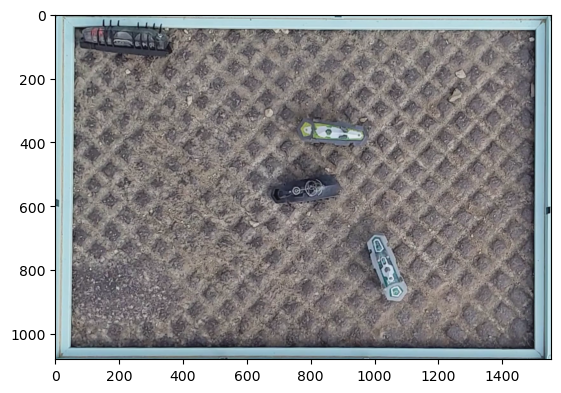

In [36]:
plt.imshow(X[0])

In [37]:
listtest = []
tmp = []
for i, img in enumerate(X):
        
    #We can use the image_id in target to know which image it is
    
    encoding = processor(images=img, annotations=None, return_tensors="pt")
    pixel_values = encoding["pixel_values"].squeeze() # remove batch dimension
    
    device = torch.device( "cuda")
    pixel_values = pixel_values.unsqueeze(0).to(device)
    model.to(device)

    with torch.no_grad():
      # forward pass to get class logits and bounding boxes
      outputs = model(pixel_values=pixel_values, pixel_mask=None)
    # print("Outputs:", outputs.keys())

    # postprocess model outputs
    width, height = img.shape[1], img.shape[0]
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                    target_sizes=[(height, width)],
                                                                    threshold=0.74)
    results = postprocessed_outputs[0]


    j=0
    for score, label, (xmin, ymin, xmax, ymax)  in zip(results['scores'].tolist(), results['labels'].tolist(), results['boxes'].tolist()):
        center = (xmin+32.5, ymin+32.5)
        array = [int(i),int(j),xmin+32.5, ymin+32.5]
        np.set_printoptions(suppress=True)
        farray = np.array(array)
        listtest.append(farray)
        
        frame, ids, x ,y = farray
        
        if ids<=4:        
            # we create a dictionary for each roi in the correct format
            e = {
                    't': frame,
                    'hexbug': ids,
                    'x': y,
                    'y': x
                }
            tmp.append(e)
        j=j+1

listtest = np.asarray(listtest)
print(listtest.shape)
print(tmp)
    






(394, 4)
[{'t': 0.0, 'hexbug': 0.0, 'x': 564.011962890625, 'y': 711.5941772460938}, {'t': 0.0, 'hexbug': 1.0, 'x': 73.15232849121094, 'y': 128.9094467163086}, {'t': 0.0, 'hexbug': 2.0, 'x': 379.46771240234375, 'y': 950.30712890625}, {'t': 0.0, 'hexbug': 3.0, 'x': 717.9552612304688, 'y': 1009.2427978515625}, {'t': 1.0, 'hexbug': 0.0, 'x': 581.730224609375, 'y': 608.0676879882812}, {'t': 1.0, 'hexbug': 1.0, 'x': 50.92802429199219, 'y': 123.14595031738281}, {'t': 1.0, 'hexbug': 2.0, 'x': 390.8776550292969, 'y': 1010.5211181640625}, {'t': 1.0, 'hexbug': 3.0, 'x': 603.5892944335938, 'y': 1003.3455810546875}, {'t': 2.0, 'hexbug': 0.0, 'x': 570.2575073242188, 'y': 507.999755859375}, {'t': 2.0, 'hexbug': 1.0, 'x': 191.6692352294922, 'y': 122.0713119506836}, {'t': 2.0, 'hexbug': 2.0, 'x': 423.28076171875, 'y': 1088.4095458984375}, {'t': 2.0, 'hexbug': 3.0, 'x': 487.8466796875, 'y': 977.7537841796875}, {'t': 3.0, 'hexbug': 0.0, 'x': 532.2709655761719, 'y': 412.375244140625}, {'t': 3.0, 'hexbug':

(1080, 1920, 3)

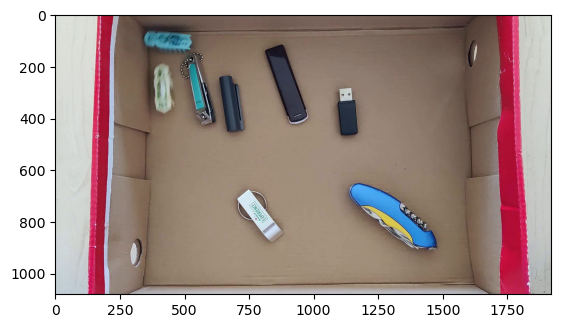

In [24]:
plt.imshow(X[0])
X[0].shape

In [25]:
for x in range(0,X[0].shape[0]):
    for y in range(0,X[0].shape[1]):
        if (x-listtest[0][3])**2 + (y-listtest[0][2])**2 <= 15**2:
            X[0][x][y] = 1

IndexError: list index out of range

(1080, 1920, 3)

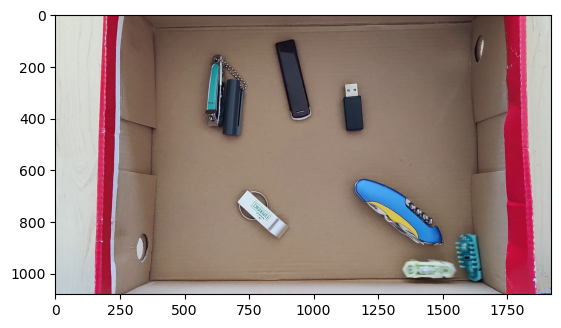

In [23]:
plt.imshow(X[100])
X[100].shape

In [38]:
import pandas as pd
def save_list(list_with_values: list, path: str):
    df = pd.DataFrame(list_with_values)
    df = df.sort_values(by = ['hexbug', 't'],ignore_index=True) # we sort the values by hexbug and frame
    # now the values are in the correct order, so we save the csv file
    print('Saving to csv')
    df.to_csv(path)
    print('Done')

In [39]:
save_list(tmp, 'C:/Salil Data/Salil/Salil FAU/MSc ACES/Sem 2 Courses/Tracking Olympiad/Leaderboard test data/test003.csv')

Saving to csv
Done


In [23]:
results

{'scores': tensor([0.9994], device='cuda:0'),
 'labels': tensor([0], device='cuda:0'),
 'boxes': tensor([[400.2166, 916.0585, 463.9685, 979.3568]], device='cuda:0')}

In [31]:
import cv2
import os

input_folder = "C:\\Salil Data\\Salil\\Salil FAU\\MSc ACES\\Sem 2 Courses\\Tracking Olympiad\\Trained\\DETR resnet50 default\\Full_trainable\\5_queries\\auxloss_true\\bboxloss_inc\\Gaussian_Color\\valProbs_V9\\forppt2\\"
output_path = "C:\\Salil Data\\Salil\\Salil FAU\\MSc ACES\\Sem 2 Courses\\Tracking Olympiad\\Trained\\DETR resnet50 default\\Full_trainable\\5_queries\\auxloss_true\\bboxloss_inc\\Gaussian_Color\\valProbs_V9\\forppt2\\v.mp4"
fps = 10.0  # Frames per second (adjust as needed)
frame_size = None  # Frame size will be determined from the first image
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Codec for the output video
output_video = None


In [32]:
for filename in sorted(os.listdir(input_folder)):
    if filename.endswith(".jpg") or filename.endswith(".png"):  # Adjust file extensions as needed
        image_path = os.path.join(input_folder, filename)
        image = cv2.imread(image_path)

        # Set frame size based on the first image
        if frame_size is None:
            frame_size = (image.shape[1], image.shape[0])
            output_video = cv2.VideoWriter(output_path, fourcc, fps, frame_size)

        output_video.write(image)

output_video.release()


In [13]:

device = torch.device( "cuda")
model.to(device)
index=[]

thresholds = [0.74]
for ind in thresholds:
    index=[]
    true_positive = 0
    for i in range(3021):
        #We can use the image_id in target to know which image it is
        pixel_values, target = val_dataset[i]
        pixel_values = pixel_values.unsqueeze(0).to(device) 

        with torch.no_grad():
            # forward pass to get class logits and bounding boxes
            outputs = model(pixel_values=pixel_values, pixel_mask=None)

        # postprocess model outputs
        width = target['size'][0]
        height = target['size'][1]
        postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                            target_sizes=[(height, width)],
                                                                            threshold=ind)
        results = postprocessed_outputs[0]

        if ((results['boxes'].shape[0])) == (target['boxes'].shape[0]):
            true_positive = true_positive+1
            
        else:
            index.append(i)

    print("true positive:", true_positive, ", total:", i+1, ", threshold:", ind)
    print(index)


    


true positive: 2926 , total: 3021 , threshold: 0.74
[77, 112, 113, 116, 117, 169, 170, 171, 177, 230, 288, 293, 415, 450, 469, 472, 598, 633, 678, 693, 697, 732, 766, 783, 786, 806, 859, 899, 1000, 1010, 1020, 1048, 1077, 1156, 1303, 1404, 1630, 1810, 1822, 1823, 1829, 1836, 1841, 1842, 1843, 1844, 1847, 1848, 1849, 1852, 1855, 1856, 1858, 1861, 1874, 1878, 1883, 1884, 1886, 1887, 1888, 1896, 1897, 1898, 1899, 1900, 1907, 1909, 2010, 2174, 2186, 2313, 2344, 2616, 2624, 2666, 2744, 2745, 2746, 2747, 2748, 2766, 2768, 2769, 2773, 2774, 2775, 2783, 2790, 2795, 2803, 2804, 2892, 2908, 2914]


In [ ]:
# VERSION 17

# true positive: 2926 , total: 3021 , threshold: 0.74
# [77, 112, 113, 116, 117, 169, 170, 171, 177, 230, 288, 293, 415, 450, 469, 472, 598, 633, 678, 693, 697, 732, 766, 783, 786, 806, 859, 899, 1000, 1010, 1020, 1048, 1077, 1156, 1303, 1404, 1630, 1810, 1822, 1823, 1829, 1836, 1841, 1842, 1843, 1844, 1847, 1848, 1849, 1852, 1855, 1856, 1858, 1861, 1874, 1878, 1883, 1884, 1886, 1887, 1888, 1896, 1897, 1898, 1899, 1900, 1907, 1909, 2010, 2174, 2186, 2313, 2344, 2616, 2624, 2666, 2744, 2745, 2746, 2747, 2748, 2766, 2768, 2769, 2773, 2774, 2775, 2783, 2790, 2795, 2803, 2804, 2892, 2908, 2914]

# true positive: 968 , total: 999 , threshold: 0.63
# [32, 112, 113, 116, 117, 130, 168, 169, 170, 171, 177, 178, 230, 288, 293, 450, 469, 598, 633, 660, 678, 693, 697, 732, 766, 783, 786, 806, 859, 879, 899]

# true positive: 969 , total: 999 , threshold: 0.65
# [32, 112, 113, 116, 117, 168, 169, 170, 171, 177, 230, 288, 293, 415, 450, 469, 598, 633, 660, 678, 693, 697, 732, 766, 783, 786, 806, 859, 879, 899]

# true positive: 970 , total: 999 , threshold: 0.67
# [112, 113, 116, 117, 168, 169, 170, 171, 177, 230, 288, 293, 415, 450, 469, 598, 633, 660, 678, 693, 697, 732, 766, 783, 786, 806, 859, 879, 899]

# true positive: 970 , total: 999 , threshold: 0.69
# [112, 113, 116, 117, 168, 169, 170, 171, 177, 230, 288, 293, 415, 450, 469, 598, 633, 660, 678, 693, 697, 732, 766, 783, 786, 806, 859, 879, 899]

# true positive: 971 , total: 999 , threshold: 0.71
# [112, 113, 116, 117, 168, 169, 170, 171, 177, 230, 288, 293, 415, 450, 469, 472, 598, 633, 678, 693, 697, 732, 766, 783, 786, 806, 859, 899]

# true positive: 971 , total: 999 , threshold: 0.73
# [77, 112, 113, 116, 117, 169, 170, 171, 177, 230, 288, 293, 415, 450, 469, 472, 598, 633, 678, 693, 697, 732, 766, 783, 786, 806, 859, 899]

# true positive: 971 , total: 999 , threshold: 0.74
# [77, 112, 113, 116, 117, 169, 170, 171, 177, 230, 288, 293, 415, 450, 469, 472, 598, 633, 678, 693, 697, 732, 766, 783, 786, 806, 859, 899]

# true positive: 971 , total: 999 , threshold: 0.75
# [77, 112, 113, 116, 117, 169, 170, 171, 177, 230, 288, 293, 415, 450, 469, 472, 598, 633, 678, 693, 697, 732, 766, 783, 786, 806, 859, 899]

# true positive: 971 , total: 999 , threshold: 0.77
# [77, 112, 113, 116, 117, 169, 170, 171, 177, 230, 288, 293, 415, 450, 469, 472, 598, 633, 678, 693, 697, 732, 766, 783, 786, 806, 859, 899]

# true positive: 971 , total: 999 , threshold: 0.79
# [77, 112, 113, 116, 117, 169, 170, 171, 177, 230, 288, 293, 415, 450, 469, 472, 598, 633, 678, 693, 697, 732, 766, 783, 786, 806, 859, 899]

# true positive: 970 , total: 999 , threshold: 0.81
# [77, 112, 113, 116, 117, 130, 169, 170, 171, 177, 230, 288, 293, 415, 469, 472, 598, 633, 660, 678, 693, 697, 732, 766, 783, 786, 806, 859, 899]

# true positive: 967 , total: 999 , threshold: 0.83
# [77, 112, 113, 114, 116, 117, 130, 169, 170, 171, 177, 230, 288, 293, 414, 415, 417, 469, 472, 598, 633, 660, 678, 693, 697, 732, 760, 766, 783, 786, 806, 899]

# true positive: 966 , total: 999 , threshold: 0.85
# [77, 112, 113, 114, 116, 117, 130, 137, 169, 170, 171, 177, 230, 288, 293, 414, 415, 417, 469, 472, 598, 633, 660, 678, 693, 697, 732, 760, 766, 783, 786, 806, 899]

# true positive: 964 , total: 999 , threshold: 0.87
# [77, 112, 113, 114, 116, 117, 130, 137, 170, 171, 176, 177, 179, 230, 288, 293, 414, 415, 417, 469, 472, 598, 633, 660, 678, 693, 697, 732, 760, 766, 782, 783, 786, 806, 899]


In [ ]:
#Version 10

# true positive: 2907 , total: 3021 , threshold: 0.7
# [31, 32, 34, 70, 77, 111, 112, 115, 116, 157, 168, 169, 172, 174, 183, 256, 257, 293, 469, 679, 697, 710, 714, 723, 785, 786, 787, 789, 899, 1000, 1048, 1049, 1053, 1119, 1120, 1156, 1166, 1173, 1303, 1404, 1490, 1654, 1668, 1671, 1761, 1809, 1820, 1828, 1829, 1833, 1841, 1842, 1843, 1844, 1846, 1847, 1849, 1853, 1854, 1855, 1856, 1857, 1858, 1865, 1881, 1883, 1884, 1887, 1888, 1897, 1899, 2010, 2171, 2315, 2318, 2326, 2337, 2344, 2349, 2398, 2616, 2639, 2640, 2652, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2760, 2768, 2772, 2773, 2777, 2782, 2783, 2784, 2786, 2787, 2788, 2789, 2791, 2794, 2796, 2802, 2804, 2890, 2891, 2895, 2897, 2908, 2968]

# true positive: 965 , total: 999 , threshold: 0.6

# true positive: 969 , total: 999 , threshold: 0.65

# true positive: 969 , total: 999 , threshold: 0.66

# true positive: 969 , total: 999 , threshold: 0.67

# true positive: 968 , total: 999 , threshold: 0.69

# true positive: 970 , total: 999 , threshold: 0.7
# [31, 32, 34, 70, 77, 111, 112, 115, 116, 143, 157, 168, 169, 170, 172, 174, 183, 256, 257, 293, 469, 679, 697, 710, 714, 723, 785, 786, 787, 789, 899, 31, 32, 34, 70, 77, 111, 112, 115, 116, 157, 168, 169, 172, 174, 183, 256, 257, 293, 469, 679, 697, 710, 714, 723, 785, 786, 787, 789, 899]

# true positive: 970 , total: 999 , threshold: 0.71
# [31, 32, 34, 70, 77, 111, 112, 115, 116, 143, 157, 168, 169, 170, 172, 174, 183, 256, 257, 293, 469, 679, 697, 710, 714, 723, 785, 786, 787, 789, 899, 31, 32, 34, 70, 77, 111, 112, 115, 116, 157, 168, 169, 172, 174, 183, 256, 257, 293, 469, 679, 697, 710, 714, 723, 785, 786, 787, 789, 899, 31, 32, 34, 70, 77, 111, 112, 115, 116, 157, 168, 169, 172, 174, 183, 256, 257, 293, 469, 679, 697, 710, 714, 723, 785, 786, 787, 789, 899]

# true positive: 969 , total: 999 , threshold: 0.72

# true positive: 969 , total: 999 , threshold: 0.73

# true positive: 969 , total: 999 , threshold: 0.74

# true positive: 969 , total: 999 , threshold: 0.75
# [31, 32, 34, 70, 77, 111, 112, 115, 116, 157, 168, 169, 172, 174, 183, 256, 257, 293, 469, 679, 697, 710, 714, 723, 783, 785, 786, 787, 789, 899]

# true positive: 967 , total: 999 , threshold: 0.76

# true positive: 966 , total: 999 , threshold: 0.77

# true positive: 965 , total: 999 , threshold: 0.78

# true positive: 965 , total: 999 , threshold: 0.79

# true positive: 965 , total: 999 , threshold: 0.81
# [31, 34, 70, 77, 111, 112, 115, 116, 124, 128, 143, 169, 171, 172, 173, 174, 183, 184, 194, 256, 257, 293, 469, 679, 697, 710, 723, 783, 785, 786, 787, 788, 789, 899]

# true positive: 964 , total: 999 , threshold: 0.82
# true positive: 963 , total: 999 , threshold: 0.83
# true positive: 964 , total: 999 , threshold: 0.84
# true positive: 965 , total: 999 , threshold: 0.85
# true positive: 965 , total: 999 , threshold: 0.86
# true positive: 964 , total: 999 , threshold: 0.87
# true positive: 959 , total: 999 , threshold: 0.88
# true positive: 956 , total: 999 , threshold: 0.89
# true positive: 952 , total: 999 , threshold: 0.9


In [10]:
#Version 9
# true positive: 965 , total: 999 , threshold: 0.81
# true positive: 965 , total: 999 , threshold: 0.82
# true positive: 965 , total: 999 , threshold: 0.83
# true positive: 967 , total: 999 , threshold: 0.84
# true positive: 965 , total: 999 , threshold: 0.85
# true positive: 965 , total: 999 , threshold: 0.86
# true positive: 965 , total: 999 , threshold: 0.87
# true positive: 963 , total: 999 , threshold: 0.88

# true positive: 963 , total: 999 , threshold: 0.89
# true positive: 961 , total: 999 , threshold: 0.9
# true positive: 960 , total: 999 , threshold: 0.91
# true positive: 958 , total: 999 , threshold: 0.92
# true positive: 957 , total: 999 , threshold: 0.93
# true positive: 953 , total: 999 , threshold: 0.94
# true positive: 949 , total: 999 , threshold: 0.95
# true positive: 946 , total: 999 , threshold: 0.96
# true positive: 940 , total: 999 , threshold: 0.97
# true positive: 924 , total: 999 , threshold: 0.98
# true positive: 870 , total: 999 , threshold: 0.99

# true positive: 2890 , total: 3021 , threshold: 0.84
# [31, 59, 112, 114, 115, 116, 127, 170, 172, 173, 178, 179, 202, 211, 213, 254, 255, 257, 293, 357, 455, 617, 641, 643, 697, 711, 766, 783, 797, 848, 885, 899, 1000, 1011, 1139, 1140, 1146, 1148, 1150, 1153, 1156, 1157, 1166, 1179, 1199, 1202, 1303, 1404, 1454, 1455, 1472, 1486, 1491, 1631, 1655, 1659, 1671, 1699, 1701, 1703, 1776, 1812, 1822, 1829, 1836, 1837, 1838, 1840, 1842, 1843, 1844, 1846, 1847, 1848, 1849, 1855, 1859, 1863, 1865, 1881, 1882, 1883, 1884, 1885, 1888, 1889, 1892, 1894, 1895, 1896, 1897, 1905, 2010, 2114, 2203, 2327, 2333, 2337, 2343, 2616, 2621, 2641, 2650, 2740, 2742, 2743, 2744, 2745, 2746, 2747, 2748, 2767, 2768, 2769, 2770, 2774, 2780, 2781, 2782, 2783, 2784, 2788, 2790, 2791, 2812, 2850, 2892, 2895, 2896, 2914, 2928]

In [10]:
#Version 8
print("true positive: 967 , total: 999 , threshold: 0.92")
print("true positive: 968 , total: 999 , threshold: 0.93")
print("true positive: 968 , total: 999 , threshold: 0.94")
print("true positive: 968 , total: 999 , threshold: 0.95")
print("true positive: 965 , total: 999 , threshold: 0.96")
print("true positive: 961 , total: 999 , threshold: 0.97")
print("true positive: 956 , total: 999 , threshold: 0.98")
print("true positive: 935 , total: 999 , threshold: 0.99")

true positive: 967 , total: 999 , threshold: 0.92
true positive: 968 , total: 999 , threshold: 0.93
true positive: 968 , total: 999 , threshold: 0.94
true positive: 968 , total: 999 , threshold: 0.95
true positive: 965 , total: 999 , threshold: 0.96
true positive: 961 , total: 999 , threshold: 0.97
true positive: 956 , total: 999 , threshold: 0.98
true positive: 935 , total: 999 , threshold: 0.99


In [10]:
index

NameError: name 'index' is not defined

In [ ]:
device = torch.device( "cuda")
model.to(device)
index=[]


true_positive = 0
thresholds = 0.94
for i in range(3020):
    #We can use the image_id in target to know which image it is
    pixel_values, target = val_dataset[i]
    pixel_values = pixel_values.unsqueeze(0).to(device)

    with torch.no_grad():
        # forward pass to get class logits and bounding boxes
        outputs = model(pixel_values=pixel_values, pixel_mask=None)

    # postprocess model outputs
    width = target['size'][0]
    height = target['size'][1]
    postprocessed_outputs = processor.post_process_object_detection(outputs,
                                                                        target_sizes=[(height, width)],
                                                                        threshold=thresholds[j])
    results = postprocessed_outputs[0]

    if ((results['boxes'].shape[0])) != (target['boxes'].shape[0]):
        true_positive = true_positive+1
        
        

In [12]:
true_positive

22

In [812]:
for image, label, _ in val_dataloader:
    print(image.shape)

AttributeError: 'str' object has no attribute 'shape'

In [809]:
true_positive = 0
device = torch.device("cuda")
model.to(device)
index = []
batch_size = 1  # Adjust the batch size according to your GPU memory

for i in range(0, len(val_dataset), batch_size):
    batch_images = []
    batch_sizes = []

    for j in range(i, min(i + batch_size, len(val_dataset))):
        pixel_values, target = val_dataset[j]
        pixel_values = pixel_values.unsqueeze(0).to(device)
        batch_images.append(pixel_values)

        width = target['size'][0]
        height = target['size'][1]
        batch_sizes.append((height, width))

    batch_images = torch.cat(batch_images, dim=0)

    with torch.no_grad():
        # Forward pass to get class logits and bounding boxes
        outputs = model(pixel_values=batch_images, pixel_mask=None)

    for k in range(len(batch_images)):
        pixel_values = batch_images[k].unsqueeze(0)

        width = batch_sizes[k][0]
        height = batch_sizes[k][1]

        postprocessed_outputs = processor.post_process_object_detection(outputs[k:k+1],
                                                                       target_sizes=[(height, width)],
                                                                       threshold=0.97)
        results = postprocessed_outputs[0]

        if results['boxes'].shape[0] != target['boxes'].shape[0]:
            index.append(i + k)

        if i + k > 250:
            break


OutOfMemoryError: CUDA out of memory. Tried to allocate 58.00 MiB (GPU 0; 4.00 GiB total capacity; 3.31 GiB already allocated; 0 bytes free; 3.43 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [805]:
len(index)

30

In [798]:
accuracy = true_positive/250

In [89]:
outputs

DetrObjectDetectionOutput(loss=None, loss_dict=None, logits=tensor([[[-0.4009,  1.0091],
         [ 1.3850, -0.7488],
         [ 1.9578, -2.0961],
         [ 2.0800, -2.5255],
         [ 0.9925, -1.1959]]], device='cuda:0'), pred_boxes=tensor([[[0.9042, 0.5616, 0.0630, 0.0452],
         [0.8996, 0.5570, 0.0637, 0.0456],
         [0.8163, 0.4743, 0.0597, 0.0444],
         [0.5689, 0.1856, 0.0586, 0.0432],
         [0.5722, 0.1840, 0.0595, 0.0411]]], device='cuda:0'), auxiliary_outputs=None, last_hidden_state=tensor([[[ 0.2357, -0.3195, -0.8003,  ...,  0.2179,  2.1792,  0.5132],
         [ 0.3284, -0.0679, -0.9233,  ..., -0.0324,  1.8493,  0.6362],
         [-0.1919,  0.2155, -0.0419,  ..., -0.7757,  1.6988,  1.1523],
         [-0.7770, -0.2857, -0.3053,  ..., -0.9356,  1.6724,  0.6395],
         [-0.6401, -0.4855, -0.2966,  ..., -0.8592,  1.5326,  0.6041]]],
       device='cuda:0'), decoder_hidden_states=None, decoder_attentions=None, cross_attentions=None, encoder_last_hidden_state=ten

In [7]:
# Start tensorboard.
%reload_ext tensorboard
%tensorboard --logdir C:/Users/salil/org_size

Reusing TensorBoard on port 6006 (pid 18924), started 13:49:45 ago. (Use '!kill 18924' to kill it.)

In [45]:
import pickle

# Open the .pickle file in read binary mode
with open("C:/Salil Data/Salil/Salil FAU/MSc ACES/Sem 2 Courses/Tracking Olympiad/Trained/DETR resnet50 default/Full_trainable/5_queries/auxloss_true/processor.pkl", 'rb') as file:
    # Load the contents of the file
    data = pickle.load(file)

# Process or use the loaded data as needed
print(data)

DetrImageProcessor {
  "do_normalize": true,
  "do_pad": true,
  "do_rescale": true,
  "do_resize": true,
  "feature_extractor_type": "DetrFeatureExtractor",
  "format": "coco_detection",
  "image_mean": [
    0.485,
    0.456,
    0.406
  ],
  "image_processor_type": "DetrImageProcessor",
  "image_std": [
    0.229,
    0.224,
    0.225
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "longest_edge": 1333,
    "shortest_edge": 800
  }
}

